# Crypto Market Analysis

## Pearson Correlation Coefficient (PCC) for Model Evaluation

The Pearson correlation coefficient (ρ) measures the linear correlation between two variables, in our case between the actual labels (y) and predicted values (ŷ) on the private test set. It ranges from -1 to +1, where:

- +1 indicates perfect positive linear correlation
- 0 indicates no linear correlation  
- -1 indicates perfect negative linear correlation

# The formula for PCC is:
# 
# $\rho = \frac{Cov(y,\hat{y})}{\sigma_y \cdot \sigma_{\hat{y}}}$

Where:
- Cov(y,ŷ) is the covariance between actual and predicted values
- σy is the standard deviation of actual values
- σŷ is the standard deviation of predicted values

For this competition, the evaluation metric is the Pearson correlation between our predictions and the true labels on the private test set. A higher positive correlation indicates better predictive performance, as our predictions more closely track the actual market movements.

Key implications:
- We want our predictions to move in the same direction as actual values
- The magnitude of movements matters less than getting the direction right
- A correlation of 0.7+ would indicate strong predictive performance


In [9]:
# DRW - Crypto Market Prediction Analysis
# Import necessary libraries

import pandas as pd
import numpy as np
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import joblib
import os
import zipfile
import gc
from lightgbm import LGBMRegressor
from sklearn.inspection import permutation_importance
import warnings
from sklearn.base import clone
from xgboost import XGBRegressor
from scipy.stats import pearsonr
from koolbox import Trainer
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr as pr


warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to analyze DRW Crypto Market Prediction data...")


Libraries imported successfully!
Ready to analyze DRW Crypto Market Prediction data...


## Load the data

In [3]:
# Load and examine the crypto market data
# First, let's identify the main data files (both CSV and Parquet)
data_dir = "./data/"
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith('.csv')]
parquet_files = [f for f in all_files if f.endswith('.parquet')]

# Load the main dataset(s)
train_data = None
test_data = None
sample_submission = None

# Function to load data based on file extension
def load_data_file(filepath):
    if filepath.endswith('.csv'):
        return pd.read_csv(filepath)
    elif filepath.endswith('.parquet'):
        return pd.read_parquet(filepath)
    else:
        raise ValueError(f"Unsupported file format: {filepath}")

# Try to identify train, test, and submission files
all_data_files = csv_files + parquet_files
for file in all_data_files:
    filepath = os.path.join(data_dir, file)
    
    if 'train' in file.lower():
        train_data = load_data_file(filepath)
        
    elif 'test' in file.lower() and 'submission' not in file.lower():
        test_data = load_data_file(filepath)
        
    elif 'submission' in file.lower():
        sample_submission = load_data_file(filepath)


# Display basic information about the datasets
if train_data is not None:
    print("\nTraining Data:")
    print(f"Shape: {train_data.shape}")
    print("\nFirst few rows (showing first 7 columns):")
    print(train_data.iloc[:5, :7])

if test_data is not None:
    print("\nTest Data:")
    print(f"Shape: {test_data.shape}")
    print("\nFirst few rows (showing first 7 columns):")
    print(test_data.iloc[:5, :7])

if sample_submission is not None:
    print("\nSample Submission:")
    print(f"Shape: {sample_submission.shape}")
    print("\nFirst few rows:")
    print(sample_submission.head())

if train_data is None and test_data is None:
    print("No train or test data loaded. Please check if the data files exist.")



Training Data:
Shape: (525887, 896)

First few rows (showing first 7 columns):
                     bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
timestamp                                                                     
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.121263   
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.302841   
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.167462   
2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.072944   
2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.173820   

                           X2  
timestamp                      
2023-03-01 00:00:00 -0.417690  
2023-03-01 00:01:00 -0.049576  
2023-03-01 00:02:00 -0.291212  
2023-03-01 00:03:00 -0.436590  
2023-03-01 00:04:00 -0.213489  

Test Data:
Shape: (538150, 896)

First few rows (showing first 7 columns):
    bid_qty  ask_qty  buy_qty  sell_qty   volume        X1        

### Reduce Memory Usage

Next we need to reduce the amounr of RAM that the pandas dataframe is using. When loading data, panda often assignes default values line int64 or float64. We can reduce the memory usage by converting these to smaller datatypes. We simply need to iterate over the columns and check the min and max values of each column. If the min and max values are within the range of the smaller datatypes, we can convert the column to that datatype.

In [4]:
def reduce_mem_usage(dataframe, dataset):
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    # Select only numeric columns
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        
        if np.issubdtype(dataframe[col].dtype, np.integer):
            types = [np.int8, np.int16, np.int32, np.int64]
            for t in types:
                if c_min >= np.iinfo(t).min and c_max <= np.iinfo(t).max:
                    dataframe[col] = dataframe[col].astype(t)
                    break
        elif np.issubdtype(dataframe[col].dtype, np.floating):
            types = [np.float16, np.float32, np.float64]
            for t in types:
                if c_min >= np.finfo(t).min and c_max <= np.finfo(t).max:
                    dataframe[col] = dataframe[col].astype(t)
                    break
    
    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))
    
    return dataframe

### Seperating the data into training and testing sets

The foundation for building our models is to split the data into training and testing sets. We will use the training set to train our models and the testing set to evaluate their performance.


In [5]:
target_col = 'label'

#reduce mem usage 
train_data = reduce_mem_usage(train_data, 'train_data')
test_data = reduce_mem_usage(test_data, 'test_data')

if target_col in train_data.columns:
    X = train_data.drop(target_col, axis=1)
    y = train_data[target_col]

    if target_col in test_data.columns:
        X_test = test_data.drop(target_col, axis=1)
    else:
        X_test = test_data.copy() # Use .copy() to avoid SettingWithCopyWarning later

    # Replace infinite values with NaN, which is XGBoost's default for missing values.
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows where target is NaN, as they are not useful for training or evaluation.
    if y.isnull().any():
        print(f"Target variable has {y.isnull().sum()} NaN values, removing corresponding rows.")
        X = X[y.notnull()]
        y = y[y.notnull()]

    print("Data successfully split into training and testing sets.")
    print(f"X (training features) shape: {X.shape}")
    print(f"y (training target) shape: {y.shape}")
    print(f"X_test (test features) shape: {X_test.shape}")

else:
    print(f"Error: Target column '{target_col}' not found in the training data.")
    print("Please update the 'target_col' variable with the correct column name.")


Reducing memory usage for: train_data
--- Memory usage before: 3598.94 MB
--- Memory usage after: 965.94 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test_data
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased memory usage by 73.2%

Data successfully split into training and testing sets.
X (training features) shape: (525887, 895)
y (training target) shape: (525887,)
X_test (test features) shape: (538150, 895)


### Black Box Feature Selection

In [ ]:
# Define model parameters (inspired by the other notebook for consistency)
lgbm_params = {
    "boosting_type": "gbdt", "n_estimators": 200, "random_state": 42,
    "n_jobs": -1, "verbose": -1, "learning_rate": 0.05
}

xgb_params = {
    "tree_method": "hist", "n_estimators": 200, "random_state": 42,
    "n_jobs": -1, "verbosity": 0, "learning_rate": 0.05
}

# Train LightGBM model on all features
print("Training LightGBM model for feature importance...")
lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(X, y)
print("Done.")

# Train XGBoost model on all features
print("Training XGBoost model for feature importance...")
xgb = XGBRegressor(**xgb_params)
xgb.fit(X, y)
print("Done.")



Training LightGBM model for feature importance...
Done.
Training XGBoost model for feature importance...
Done.


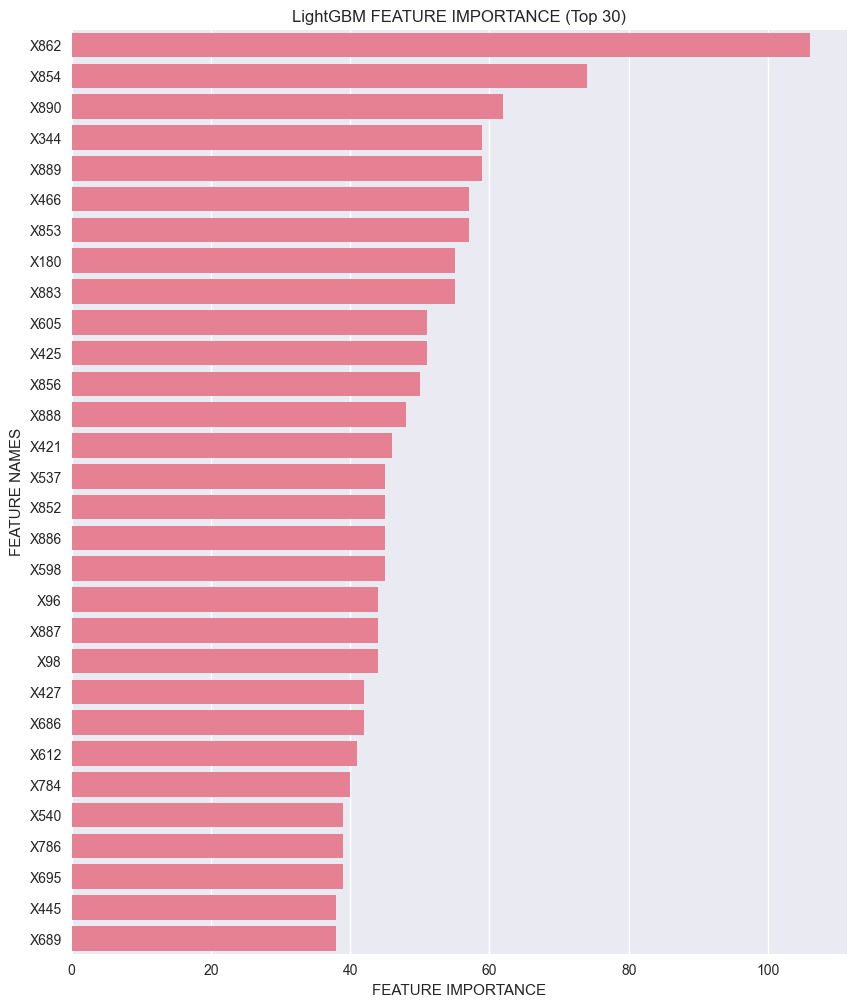

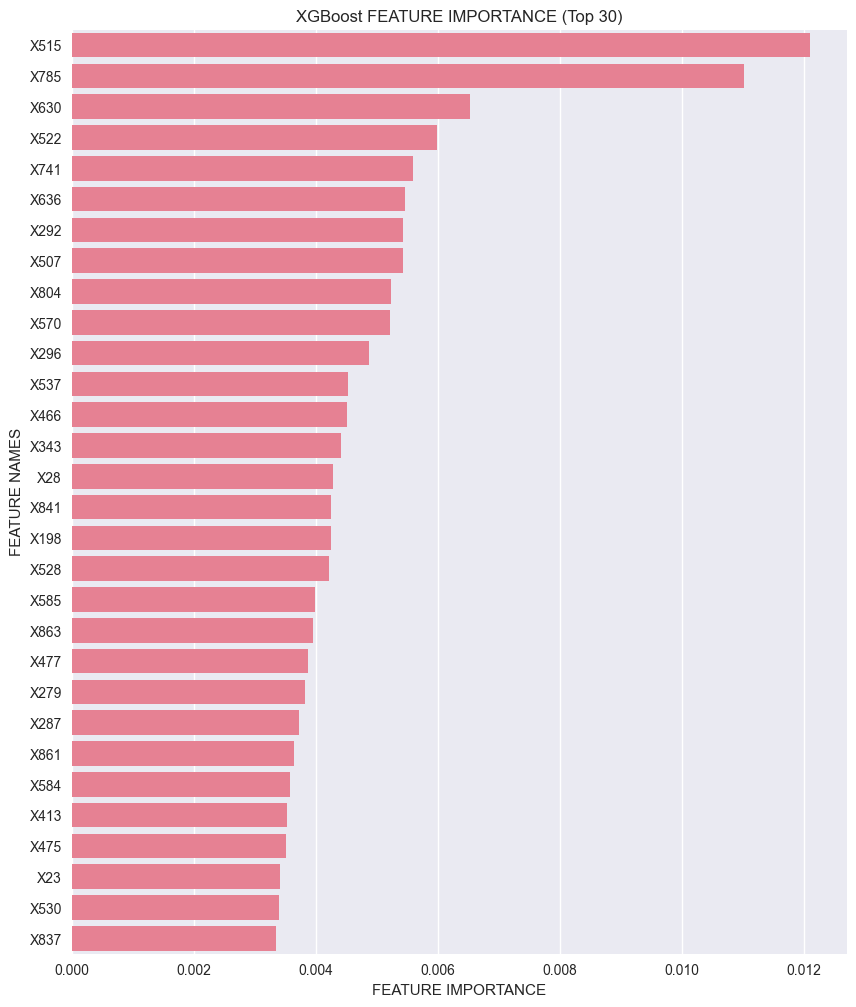

1314

In [ ]:
# --- Function for Plotting Feature Importances ---
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10,12))
    sns.barplot(x=fi_df['feature_importance'][:30], y=fi_df['feature_names'][:30])
    plt.title(model_type + ' FEATURE IMPORTANCE (Top 30)')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

# Plot the importances
plot_feature_importance(lgbm.feature_importances_, X.columns, 'LightGBM')
plot_feature_importance(xgb.feature_importances_, X.columns, 'XGBoost')

# Clean up memory
del lgbm, xgb
gc.collect()

Calculating feature correlations with target...


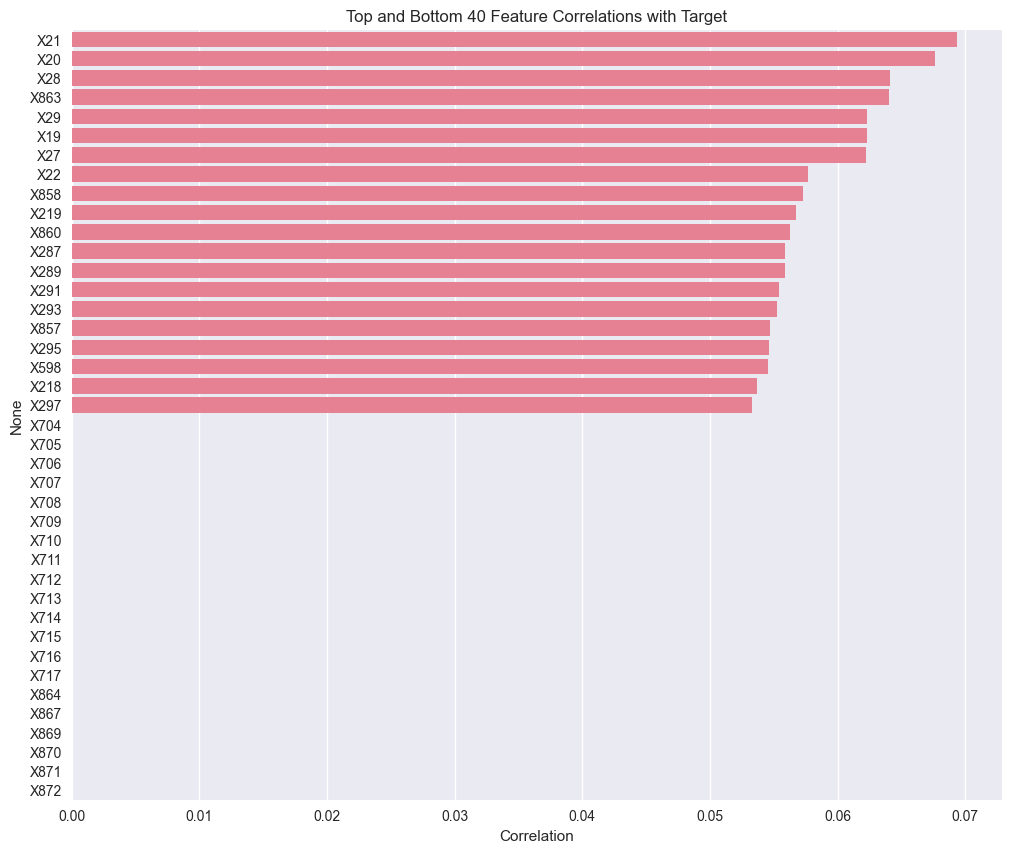

Done.


16889

In [ ]:
print("Calculating feature correlations with target...")
# Calculate correlation of each feature with the target
correlations = X.corrwith(y).sort_values(ascending=False)

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(correlations, columns=['Correlation'])

# Plot the most and least correlated features
plt.figure(figsize=(12, 10))
# We'll plot the top 20 and bottom 20
top_and_bottom_corr = pd.concat([corr_df.head(20), corr_df.tail(20)])
sns.barplot(x=top_and_bottom_corr['Correlation'], y=top_and_bottom_corr.index)
plt.title('Top and Bottom 20 Feature Correlations with Target')
plt.show()

print("Done.")
del correlations, corr_df, top_and_bottom_corr
gc.collect()

Running Permutation Importance analysis...
Using 131471 samples for permutation importance (25%) of the data.


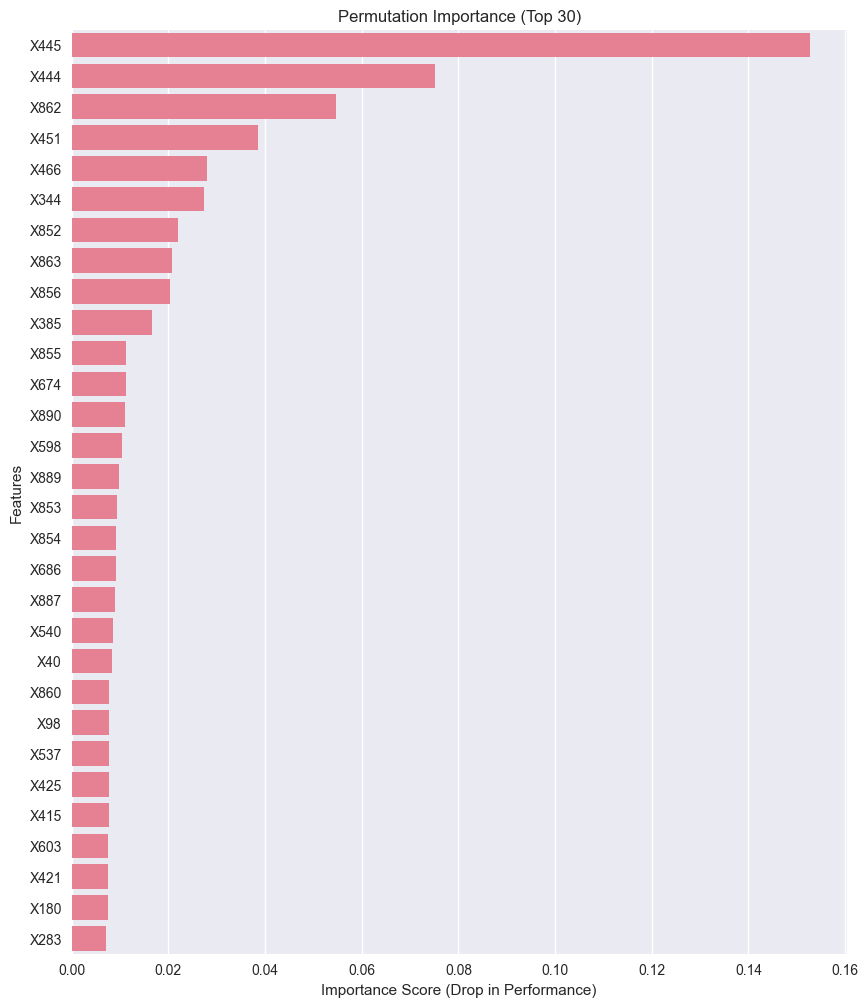

Done.


28512

In [ ]:
print("Running Permutation Importance analysis...")
# Re-train a LightGBM model to use for permutation importance
lgbm_perm = LGBMRegressor(**lgbm_params)
lgbm_perm.fit(X, y)

# NOTE: This can be slow. We use max_samples to run it on a subset of the data.
# n_repeats is how many times to shuffle each feature. 3-5 is a good value.

# Instead of a fixed sample size, we'll use a fraction of the dataset.
# This is more robust and adapts if the dataset size changes.
# A 20-30% sample is often a good starting point.
sample_fraction = 0.25
n_samples = int(X.shape[0] * sample_fraction)
print(f"Using {n_samples} samples for permutation importance ({sample_fraction:.0%}) of the data.")

# We use the max_samples parameter, which is more memory-efficient 
# and preserves the original float64 data type.
perm_importance = permutation_importance(
    lgbm_perm,
    X,  # Pass the full DataFrame
    y,  # Pass the full Series
    n_repeats=5,
    random_state=42,
    n_jobs=4,  # Still limit parallel jobs to prevent memory explosion
    max_samples=n_samples  # Let scikit-learn handle the sampling
)

# Organize results into a DataFrame
sorted_idx = perm_importance.importances_mean.argsort()
perm_df = pd.DataFrame(
    perm_importance.importances_mean[sorted_idx],
    X.columns[sorted_idx],
    columns=['Importance']
).sort_values(by='Importance', ascending=False)


# Plot top 30 features from permutation importance
plt.figure(figsize=(10, 12))
sns.barplot(x=perm_df['Importance'][:30], y=perm_df.index[:30])
plt.title('Permutation Importance (Top 30)')
plt.xlabel('Importance Score (Drop in Performance)')
plt.ylabel('Features')
plt.show()
print("Done.")

del lgbm_perm, perm_importance, perm_df
gc.collect()

In [ ]:
# Define the list of features identified as most important through prior analysis.
# This combines domain-specific features and data-driven anonymous features.

features = [
    # Top features identified 
    'X445', 'X444', 'X862', 'X451', 'X466', 'X344', 'X852', 'X863', 'X856', 'X865', 
    'X874', 'X790', 'X598', 'X889', 'X853', 'X854', 'X866', 'X887', 'X540', 'X40', 
    'X860', 'X98', 'X537', 'X415', 'X603', 'X421', 'X180', 'X283',
    
    # Core market microstructure features
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"
]

X = X[features]
X_test = X_test[features]

print("Feature selection applied.")
print(f"New shape of X (training features): {X.shape}")
print(f"New shape of X_test (test features): {X_test.shape}")

def pearsonr(y_true, y_pred):
    return pr(y_true, y_pred)[0]

Feature selection applied.
New shape of X (training features): (525887, 33)
New shape of X_test (test features): (538150, 33)


In [ ]:

xgb_params = {
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0
}

fold_scores = {}
overall_scores = {}
oof_preds = {}
test_preds = {}

xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

xgb_trainer.fit(X, y)

fold_scores["XGBoost"] = xgb_trainer.fold_scores
overall_scores["XGBoost"] = [pearsonr(xgb_trainer.oof_preds, y)]
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

print("XGBoost training complete.")
print(f"Fold Scores: {fold_scores['XGBoost']}")
print(f"Overall OOF Score: {overall_scores['XGBoost'][0]}")

Training XGBRegressor

--- Fold 0 - pearsonr: 0.230999 - Time: 10.33 s
--- Fold 1 - pearsonr: 0.074495 - Time: 10.07 s
--- Fold 2 - pearsonr: 0.115954 - Time: 10.21 s
--- Fold 3 - pearsonr: 0.143045 - Time: 10.08 s
--- Fold 4 - pearsonr: 0.126055 - Time: 10.10 s

------ Overall pearsonr: 0.132761 - Mean pearsonr: 0.138110 ± 0.051645 - Time: 51.29 s
XGBoost training complete.
Fold Scores: [np.float32(0.23099922), np.float32(0.07449515), np.float32(0.115954295), np.float32(0.14304546), np.float32(0.12605461)]
Overall OOF Score: 0.132761473586674


In [ ]:
catboost_params = {
    'iterations': 1500,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 3.5,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': 0,
    'colsample_bylevel': 0.7,
    'subsample': 0.7,
    'bootstrap_type': 'Bernoulli',
    'leaf_estimation_method': 'Newton'
}

catboost_trainer = Trainer(
    CatBoostRegressor(**catboost_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

catboost_trainer.fit(X, y)

fold_scores["CatBoost"] = catboost_trainer.fold_scores
overall_scores["CatBoost"] = [pearsonr(catboost_trainer.oof_preds, y)]
oof_preds["CatBoost"] = catboost_trainer.oof_preds
test_preds["CatBoost"] = catboost_trainer.predict(X_test)

print("\nCatBoost training complete.")
print(f"Fold Scores: {fold_scores['CatBoost']}")
print(f"Overall OOF Score: {overall_scores['CatBoost'][0]}")

Training CatBoostRegressor

--- Fold 0 - pearsonr: 0.134946 - Time: 63.10 s
--- Fold 1 - pearsonr: 0.023607 - Time: 64.15 s
--- Fold 2 - pearsonr: 0.075084 - Time: 63.02 s
--- Fold 3 - pearsonr: 0.154858 - Time: 62.98 s
--- Fold 4 - pearsonr: 0.079894 - Time: 63.48 s

------ Overall pearsonr: 0.086448 - Mean pearsonr: 0.093678 ± 0.046672 - Time: 317.21 s

CatBoost training complete.
Fold Scores: [np.float64(0.13494601637876083), np.float64(0.023607412346203022), np.float64(0.07508448572231395), np.float64(0.1548577249240383), np.float64(0.07989447946675711)]
Overall OOF Score: 0.0864479774711095


In [ ]:

mlp_params = {
    'hidden_layer_sizes': (128, 64, 32),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.001,
    'batch_size': 256,
    'learning_rate': 'adaptive',
    'max_iter': 500,
    'random_state': 42,
    'early_stopping': True,
    'n_iter_no_change': 10,
    'verbose': False
}

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(**mlp_params))
])

mlp_trainer = Trainer(
    mlp_pipeline,
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

mlp_trainer.fit(X, y)

fold_scores["MLP"] = mlp_trainer.fold_scores
overall_scores["MLP"] = [pearsonr(mlp_trainer.oof_preds, y)]
oof_preds["MLP"] = mlp_trainer.oof_preds
test_preds["MLP"] = mlp_trainer.predict(X_test)

print("\nMLP training complete.")
print(f"Fold Scores: {fold_scores['MLP']}")
print(f"Overall OOF Score: {overall_scores['MLP'][0]}")

Training Pipeline

--- Fold 0 - pearsonr: 0.097829 - Time: 117.81 s
--- Fold 1 - pearsonr: 0.012517 - Time: 146.64 s
--- Fold 2 - pearsonr: 0.028674 - Time: 114.32 s
--- Fold 3 - pearsonr: 0.127280 - Time: 148.87 s
--- Fold 4 - pearsonr: -0.000349 - Time: 222.14 s

------ Overall pearsonr: 0.046532 - Mean pearsonr: 0.053190 ± 0.050207 - Time: 750.22 s

MLP training complete.
Fold Scores: [np.float64(0.09782941586040433), np.float64(0.012516625553171071), np.float64(0.028674136768858816), np.float64(0.1272797959911381), np.float64(-0.00034885009206360104)]
Overall OOF Score: 0.04653192217858618


In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)


elasticnet_params = {
    'alpha': 0.001,      
    'l1_ratio': 0.5,     
    'random_state': 42,
    'max_iter': 2000 
}

elasticnet_trainer = Trainer(
    ElasticNet(**elasticnet_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
elasticnet_trainer.fit(X_scaled, y)

fold_scores["ElasticNet"] = elasticnet_trainer.fold_scores
overall_scores["ElasticNet"] = [pearsonr(elasticnet_trainer.oof_preds, y)]
oof_preds["ElasticNet"] = elasticnet_trainer.oof_preds
test_preds["ElasticNet"] = elasticnet_trainer.predict(X_test_scaled)

print("\nElasticNet training complete.")
print(f"Fold Scores: {fold_scores['ElasticNet']}")
print(f"Overall OOF Score: {overall_scores['ElasticNet'][0]}")

Training ElasticNet

--- Fold 0 - pearsonr: 0.231875 - Time: 3.19 s
--- Fold 1 - pearsonr: 0.080509 - Time: 2.85 s
--- Fold 2 - pearsonr: 0.040099 - Time: 3.10 s
--- Fold 3 - pearsonr: 0.138904 - Time: 7.23 s
--- Fold 4 - pearsonr: 0.079184 - Time: 2.86 s

------ Overall pearsonr: 0.090723 - Mean pearsonr: 0.114114 ± 0.066798 - Time: 19.68 s

ElasticNet training complete.
Fold Scores: [np.float64(0.2318754583470098), np.float64(0.08050859164240443), np.float64(0.04009862419183703), np.float64(0.13890376810253718), np.float64(0.0791840577018239)]
Overall OOF Score: 0.09072281398312454


In [ ]:

oof_df = pd.DataFrame(oof_preds)
print("Out-of-Fold (OOF) predictions from base models (first 5 rows):")
display(oof_df.head())

test_preds_df = pd.DataFrame(test_preds)
print("\nTest predictions from base models (first 5 rows):")
display(test_preds_df.head())

print("\nCorrelation of OOF predictions between models:")
display(oof_df.corr())

X_meta = oof_df
y_meta = y

X_test_meta = test_preds_df

print("\n--- Training Stacking Ensemble with Ridge ---")

ridge_trainer = Trainer(
    Ridge(alpha=0.1),
    cv=KFold(n_splits=5, shuffle=False),  
    metric=pearsonr,
    task="regression",
    metric_precision=6
)


ridge_trainer.fit(X_meta, y_meta)

ensemble_oof_score = pearsonr(y_meta, ridge_trainer.oof_preds)
print(f"\nEnsemble OOF Pearson Score (from CV): {ensemble_oof_score:.6f}")

ensemble_test_preds = ridge_trainer.predict(X_test_meta)
print(f"\nFinal ensemble predictions generated for {len(ensemble_test_preds)} test samples.")

final_ridge_model = Ridge(alpha=0.1).fit(X_meta, y_meta)
ensemble_weights = final_ridge_model.coef_

print("\n--- Ensemble Weights ---")
weights_df = pd.DataFrame({
    'Model': X_meta.columns,
    'Weight': ensemble_weights
}).sort_values(by='Weight', ascending=False)
display(weights_df)

Out-of-Fold (OOF) predictions from base models (first 5 rows):


,XGBoost,CatBoost,MLP,ElasticNet
0,0.024895,-0.187062,2.066253,0.356378
1,0.177502,0.006470,2.083812,0.314877
2,0.007100,-0.127733,2.019103,0.284450
3,0.018725,-0.032382,1.800356,0.285685
4,0.023405,0.035758,1.598470,0.309121



Test predictions from base models (first 5 rows):


,XGBoost,CatBoost,MLP,ElasticNet
0,0.310091,0.270505,0.210271,0.314606
1,0.094803,-0.093481,-0.900664,-0.130682
2,0.068538,-0.017720,0.436826,0.095090
3,-0.076523,-0.121355,-0.513783,-0.008815
4,0.420333,0.287016,-0.143175,0.287689



Correlation of OOF predictions between models:


,XGBoost,CatBoost,MLP,ElasticNet
XGBoost,1.000000,0.715722,0.341756,0.560654
CatBoost,0.715722,1.000000,0.461104,0.481378
MLP,0.341756,0.461104,1.000000,0.344542
ElasticNet,0.560654,0.481378,0.344542,1.000000



--- Training Stacking Ensemble with Ridge ---
Training Ridge

--- Fold 0 - pearsonr: 0.245301 - Time: 0.03 s
--- Fold 1 - pearsonr: 0.080532 - Time: 0.02 s
--- Fold 2 - pearsonr: 0.109944 - Time: 0.02 s
--- Fold 3 - pearsonr: 0.125496 - Time: 0.02 s
--- Fold 4 - pearsonr: 0.112444 - Time: 0.02 s

------ Overall pearsonr: 0.108691 - Mean pearsonr: 0.134743 ± 0.057201 - Time: 0.57 s

Ensemble OOF Pearson Score (from CV): 0.108691

Final ensemble predictions generated for 538150 test samples.

--- Ensemble Weights ---


,Model,Weight
0,XGBoost,0.466530
3,ElasticNet,0.119371
2,MLP,0.001480
1,CatBoost,-0.048524


In [ ]:
overall_scores["Ensemble (Ridge)"] = {ensemble_oof_score}
fold_scores_df = pd.DataFrame(fold_scores)
overall_scores_df = pd.DataFrame(overall_scores).transpose().sort_values(by=0, ascending=False)
order = overall_scores_df.index.tolist()

min_score = overall_scores_df.values.flatten().min()
max_score = overall_scores_df.values.flatten().max()
padding = (max_score - min_score) * 0.1
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, fold_scores_df.shape[1] * 0.5))
plt.suptitle("Model Performance", fontsize=16)

boxplot = sns.boxplot(data=fold_scores_df, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title("Fold Score")
axs[0].set_xlabel("Score")
axs[0].set_ylabel("Model")

barplot = sns.barplot(x=overall_scores_df.values.flatten(), y=overall_scores_df.index, ax=axs[1], color="grey")
axs[1].set_title("Overall OOF Score (Pearson Correlation)")
axs[1].set_xlabel("Score")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

# Highlight the ensemble bars and add score labels
for i, model_name in enumerate(order):
    score = overall_scores_df.loc[model_name].values[0]
    color = 'cyan' if 'Ensemble' in model_name else '#D3D3D3' # Light grey for others
    
    # Find the corresponding boxplot patch to color it
    for patch in boxplot.artists:
        if patch.get_label() == model_name: # This might need adjustment based on how boxplot labels artists
             patch.set_facecolor(color)

    # Color barplot and add text
    barplot.patches[i].set_facecolor(color)
    barplot.text(score + (padding * 0.05), i, f'{score:.6f}', va='center', ha='left')

# Color the boxplot artists manually since direct labeling is tricky
for i, model_name in enumerate(order):
    color = 'cyan' if 'Ensemble' in model_name else '#D3D3D3'
    boxplot.artists[i].set_facecolor(color)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout for suptitle
plt.show()

In [ ]:
print("Creating submission file...")
sample_sub_path = "./CryptoMarketPrediction/sample_submission.csv"
sub = pd.read_csv(sample_sub_path)
sub["prediction"] = ensemble_test_preds
sub.to_csv(f"sub_ensemble_{overall_scores['Ensemble (Ridge)'][0]:.6f}.csv", index=False)
display(sub.head())

